In [3]:
from pendsim import sim, controller, viz, utils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import HTML

# Linearization Notebook
This notebook explores linearization: what does it mean to linearize a non-linear system?

For this purpose, we explore an inverted pendulum on a cart system:
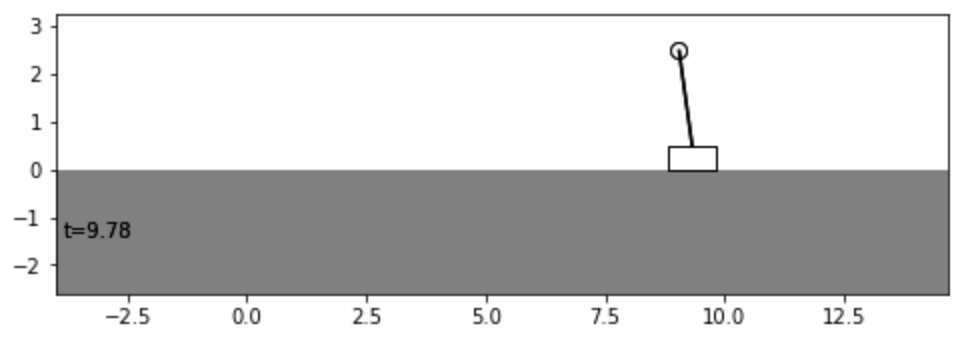
Imagine the rectangle is a cart that can move horizontally, and the pendulum is free to rotate about the point that it is attached to the cart. For simplicity, let's neglect friction and inertia. This system can be modeled using nonlinear equations of motion.

The system has the following parameters:
<ul>
<li>$M$ = mass of the cart</li>
<li>$m$ = mass on the end of the pendulum</li>
<li>$l$ = length of the pendulum</li>
<li>$g$ = gravity</li>
</ul>

The system's states that vary with time are:
<ul>
<li>$x$ = cart position</li>
<li>$\dot x$ = cart velocity</li>
<li>$\theta$ = pendulum angle (where $\theta=0$ corresponds to the upright position)</li>
<li>$\dot\theta$ = pendulum angular velocity</li>
</ul>

And some horizontal force or "push" of the cart is given by $u$.
Then the equations of motion for this system are:
    
$$ (M+m)\ddot{x} + m l \ddot{\theta}\cos{\theta} - m l \dot{\theta}^2 \sin{\theta} = u $$
$$ ml^2 \ddot{\theta} + mgl \sin{\theta} = -ml\ddot{x} \cos{\theta}$$ 
    
This is a system of nonlinear 2nd-order differential equations in terms of $x$ and $\theta$. It is highly nonlinear: we have several sines and cosines and some quadratic terms.  

We can easily produce, however, a simplified, linear approximation of the system that behaves similar to the nonlinear system in a neighborhood around a given point.

To do so, we will use techniques familiar to us from calculus.

Let's take a non-linear function, $f(x) = \sin(x)$, as an example. This looks squiggly:

Text(0.5, 0, 'x')

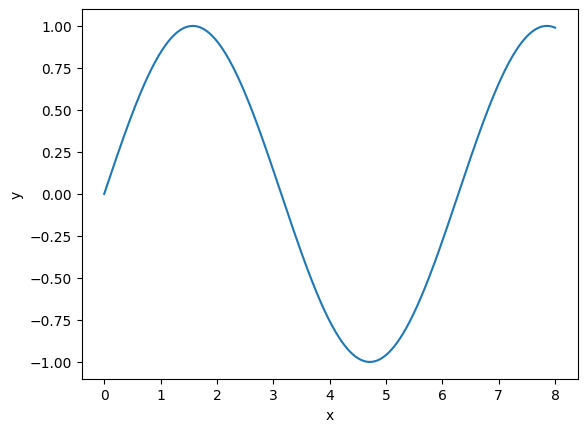

In [4]:
x = np.linspace(0,8,500)
y = np.sin(x)
plt.plot(x, y)
plt.ylabel("y")
plt.xlabel("x")

We know from calculus that we can take the derivative of this function and get its Taylor Series around any point $a$ that we want. Let's choose $x=1$.

To find the taylor series about $x=a=1$, we evaluate the function's derivative at the point of interest and use that to find the series terms:

$$f(a) + \frac{f'(a)}{1!} (x-a) + \frac{f''(a)}{2!} (x-a)^2 + \frac{f'''(a)}{3!} (x-a)^3 ... $$

Now, this series continues forever, and it's also non-linear. As we continue to add terms to the summation, the limit approaches our original function, $f(x)=\sin(x)$

In [5]:
# helper function for drawing taylor series
def taylor_plot(a, x):
    a = 1
    y = np.sin(x)
    y1 = np.repeat(np.sin(a), y.shape)
    y2 = y1 + np.cos(a) * (x-a)
    y3 = y2 - np.sin(a) * (1/2.) * (x-a)**2
    y4 = y3 - np.cos(a) * (1/6.) * (x-a)**3
    y5 = y4 + np.sin(a) * (1/24.) * (x-a)**4
    plt.axvline(a, linestyle=":", color="#090909")
    plt.plot(x, y, color="#090909")
    plt.plot(x, y1, color="#0c64dd")
    plt.plot(x, y2, color="#4983f7")
    plt.plot(x, y3, color="#80b4fa")
    plt.plot(x, y4, color="#a1d1f6")
    plt.plot(x, y5, color="#cee6fc")

We can look at some finite taylor series representations of our function $f(x)=sin(x)$; each of the different colors in this plot contains a different number of terms in the series.

Text(0.5, 0, 'x')

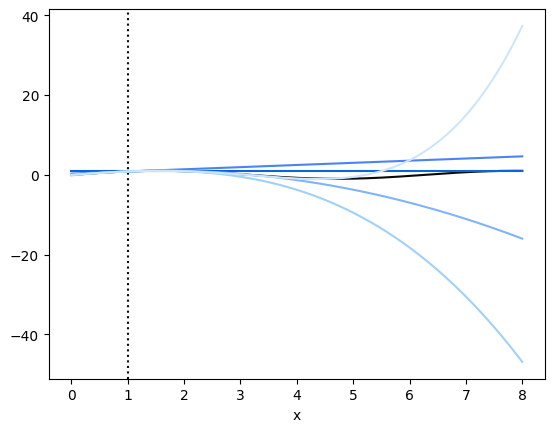

In [6]:
x = np.linspace(0,8,500)
taylor_plot(1, x)
plt.xlabel("x")

The point around which we've linearized, $a$, is marked by the vertical dotted line.

Our taylor approximations diverge a lot as we get further away from $a$, because they contain some large powers (cubics, quartics, and higher, up to infinity!). Let's look in a closer neighborhood around our linearization point.

Text(0.5, 0, 'x')

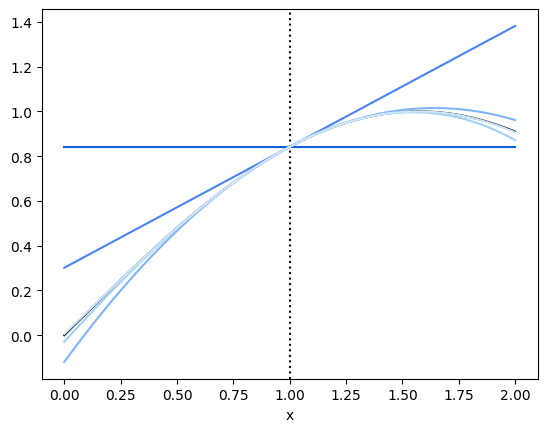

In [7]:
x = np.linspace(0, 2, 500)
taylor_plot(1, x)
plt.xlabel("x")

So here, we notice a few things. First, that the 0th order taylor approximation isn't giving us much use; it's just the function output at the point $a$. Second, that as we get more terms, we achieve a diminishing return as far as how well the function actually gets approximated. The 2nd, 3rd, 4th order terms are all very close to the 1st order term as far as accuracy, in a region close enough to the pont. So let's look at just the first-order approximation:

Text(0.5, 0, 'x')

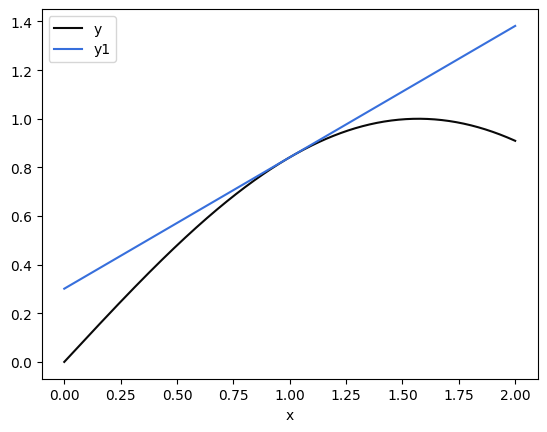

In [8]:
a = 1
# the actual function
y = np.sin(x)
# 1st order taylor approx.
y1 = np.sin(a) + np.cos(a) * (x - a)
plt.plot(x, y, '#090909', label="y")
plt.plot(x, y1, '#376fdc', label="y1")
plt.legend()
plt.xlabel("x")

This is the power of the linear approximation. For a function $f(x)$, if we can find its derivative, we can produce a "pretty good" approximation for it around any area we want. Most importantly, that first-order approximation is a *linear* approximation. We notice our `y1` function above:

$$ \sin(a) + \cos(a) (x-a) $$ 

Has the same form as the familiar line equation: 

$$ c_1 + c_2 (x) $$

As long as the point around which we are linearizing, $a$, is constant.

We can extend this line of thinking to the original pendulum system; the linearization method here works for *any* function, no matter how complex, so long as it is differentiable. It's a little bit of effort to take the derivative of the vector-valued system of ODEs we have above, so I'm only going to review it briefly here:

We represent the pendulum state as a vector: $\textbf{x} = [x, \dot{x}, \theta, \dot{\theta}]$. Here, bold $\textbf{x}$ represents the entire system, not just the cart position. With some rearranging, the original equations of motion can be written in terms of $\ddot{x}$ and $\ddot{\theta}$. The equations of motion can be written in vector form:

$$[\dot{x}, \ddot{x}, \dot{\theta}, \ddot{\theta}] = f([x, \dot{x}, \theta, \dot{\theta}]) $$

$$\dot{\textbf{x}} = f(\textbf{x})$$

In this form, the derivative of the function $f$ is the jacobian matrix of partial derivatives:

$$ \frac{\partial \textbf{x}}{\partial t} f(\textbf{x}) $$

So that the first-order taylor series approximation of the function is equal to 

$$ f_{linear}(x) = f(a) + \frac{\partial \textbf{x}}{\partial t} f(a) (x - a) $$

This approximation is often written in "state-space" form as

$$ \dot{\textbf{x}} = A \textbf{x} + B \textbf{u} $$

Now we can take steps towards our goal of finding a linear approximation for our nonlinear system. For a given state $\textbf{x} = a$, we want to find matrices $A$ and $B$ by computing the partial derivatives $\frac{\partial \textbf{x}}{\partial t} f(a)$ and rearranging the terms of the first-order Taylor Series approximation.

Which state will we linearize about?

In general, we might choose and equilibrium point (or the set point of a controller) for the linearization. Then, a well-designed controller will keep the state within the region surrounding the setpoint, and then, the linearized system model will accurately represent of the system state.

We choose $a = [0,0,0,0]$, which corresponds to the upright position and zero velocity.

After finding the derivative of our vector-valued function and rearranging some terms, we arrive at the linearized model of our original equation.

$$A = \begin{bmatrix}
0 & 1 & 0 & 0 \\
0 & 0 &\frac{m g}{M} & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & \frac{g (M+m)}{Ml} & 0 \\
\end{bmatrix} \qquad
B = \begin{bmatrix}
0 \\
\frac{1}{M} \\ 
0 \\
\frac{1}{Ml} \\
\end{bmatrix}$$

How good is the linear approximation? In order to see, we can compare the true state with the state that is predicted by the linear model. The following code gives us the linear prediction.

In [ ]:
# it's a Controller, so it will perform `policy` repeatedly in the simulation loop.
class Linearization_Measurement(controller.Controller):
    def __init__(self, pend, dt) -> None:
        self.pend = pend
        # the code to calculate the linearization is in the self.get_linear_sys method in Controller.
        self.A, self.B = self.get_linear_sys(pend.jacA, pend.jacB, dt)
        self.predicted = np.array([0,0,0.01,0])

    def policy(self, state: np.ndarray, dt: float):
        # get error from previous state
        self.err = state - self.predicted
        
        
        # predict next state
        self.predicted = self.A @ state + self.B @ np.array([0])
        action = 0
        
        # store variables
        data = {}
        data.update(utils.array_to_kv("predicted", controller.LABELS, self.predicted))
        data.update(utils.array_to_kv("pred_err", controller.LABELS, self.err))
        return action, data

Now, let's set up a simulation to investigate:

In [ ]:
dt, t_final = 0.01, 10
# start slightly tilted so that the pendulum will fall over
pend = sim.Pendulum(2, 2, 2, initial_state=np.array([0,0,0.01,0]))
cont = Linearization_Measurement(pend, dt)
simu = sim.Simulation(dt, t_final, lambda t: 0)
results = simu.simulate(pend, cont)

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5073.90it/s]


We can see how good our linearization is by looking at the difference between what was *predicted* to happen by our linearized model and what *actually* happened in the simulation.

We should notice two things. First, that at the linearization point, the difference should be very small, maybe zero. This makes sense from our plots of $sin(x)$ above. At the point $a$, the linearization produces exactly the function output. 

Second, we should notice that near the point $a$, the linearization produces a pretty good approximation of the underlying function. Remember, we might use this technique for functions that are far more complex than $sin(x)$ -- like our pendulum dynamics! And, given that we are only doing a first-order approximation, far away from the point around which we linearized our model, the linear function might not be so great an approximation.

Now we can look at the error between what the linear model predicted and what the real state was. Let's do that graphically.

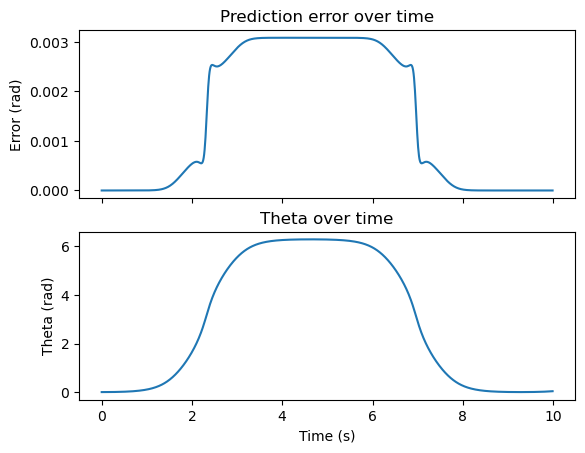

In [ ]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(results[("pred_err", "t")].abs())
ax[0].set_title("Prediction error over time")
ax[0].set_ylabel("Error (rad)")
ax[1].plot(results[("state", "t")])
ax[1].set_title("Theta over time")
ax[1].set_ylabel("Theta (rad)")
ax[1].set_xlabel("Time (s)")
plt.show()

Now we can see pretty clearly that our approximation is good near the linearization point, and decreases as we move away from it. The linearization was performed where $\theta=0$. In our simulation, this occurred at $t=0$s and at approximately $t=10$s.

 On top, we have the difference between the linear model and the actual system. On the bottom, we have the system state. 

Just like our taylor series for $\sin(x)$ above -- as we get further away from the linearization point, our 1st-order model becomes less accurate.

Finally, let's look at one more plot. Here, we plot $\theta$ on the x-axis and the prediction error on the y-axis.

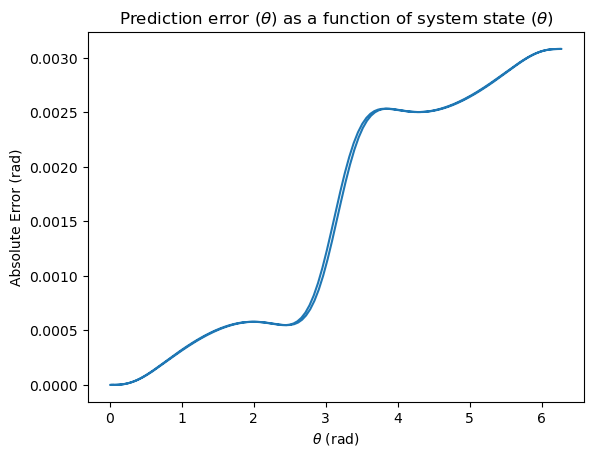

In [ ]:
fig, ax = plt.subplots()
ax.plot(results[("state", "t")].shift(1), results[("pred_err", "t")].abs())
ax.set_title(r"Prediction error ($\theta$) as a function of system state ($\theta$)")
ax.set_xlabel(r"$\theta$ (rad)")
ax.set_ylabel(r"Absolute Error (rad)")
plt.show()

Here, we see the same result. Near the linearization point of $\theta=0$, error is $0$. As we get further and further away from $\theta=0$, our approximation is less and less accurate. 

So, if our controller manages to keep the value of $\theta$ near the desired point $0$, our linearization will be accurate! This turns out to be an extremely powerful technique, because some control policies, especially those that rely on numerical optimization methods, are only possible on linear systems.